# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
import nltk
nltk.download('brown')
nltk.download('stopwords')

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

[nltk_data] Downloading package brown to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/samantharivas/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/samantharivas/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# add any additional libaries you need here

#!pip install spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='category'>

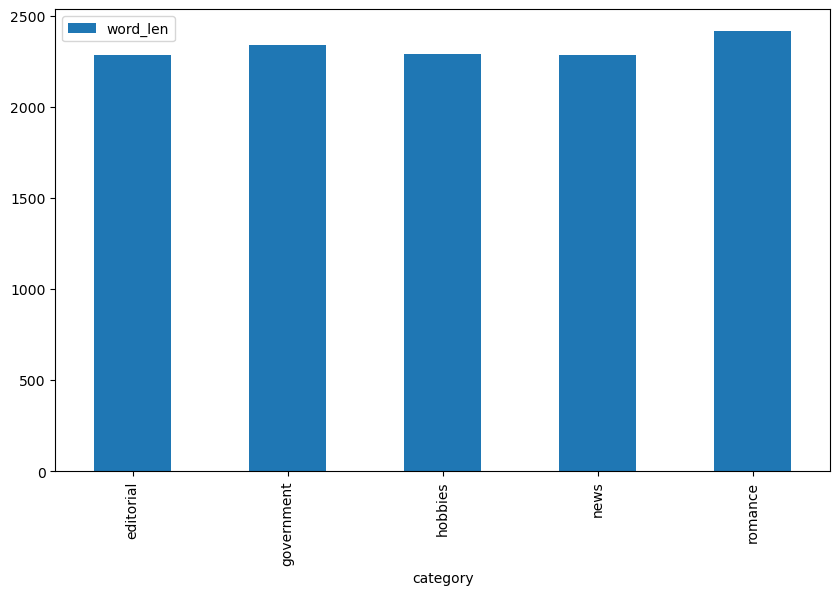

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [9]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The `count_text_vectors` contains a term-document matrix generated by the `CountVectorizer`. Each row represents an article from the Brown corpus, and each column represents a unique term from the corpus. The matrix holds the frequency of each term in each document without considering the term's weight or importance.

The `tfidf_text_vectors` is similar to the `count_text_vectors` in that each row represents a document and each column represents a unique term from the corpus. However, the values in this matrix are the TF-IDF scores, which consider both the frequency and the importance of the terms. The TF-IDF scores adjust the term frequencies by considering how common or rare the terms are across all documents in the corpus. This gives more weight to terms that are unique or less common in the corpus, reflecting their importance.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [10]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [11]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [12]:
# find dominant topic for document 
df['nmf_topic'] = W_text_matrix.argmax(axis=1)

In [13]:
# create dictionary to hold tally of categories per topic
topic_category_tally = {i: defaultdict(int) for i in range(nmf_text_model.n_components)}

# tally categories
for index, row in df.iterrows():
    topic = row['nmf_topic']
    category = row['category']
    topic_category_tally[topic][category] += 1

for topic, category_count in topic_category_tally.items():
    print(f"\nTopic {topic:02d}:")
    for category, count in category_count.items():
        print(f"  {category}: {count}")


Topic 00:
  editorial: 20
  government: 4
  news: 8

Topic 01:
  editorial: 4
  romance: 29
  hobbies: 8

Topic 02:
  editorial: 2
  government: 26
  news: 11
  hobbies: 26

Topic 03:
  news: 17
  hobbies: 1

Topic 04:
  editorial: 1
  news: 8
  hobbies: 1


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The comparison between the five-topic NMF model and the original Brown categories shows how well the model captures the content. Some topics align with categories like politics or leisure activities, while others combine different categories. This indicates that the NMF model uncovers connections and themes within the corpus that may not be immediately evident from the original categorization alone.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [14]:
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
lsa_text_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)

# create dictionary to hold tally 
topic_category_tally_lsa = {i: defaultdict(int) for i in range(lsa_text_model.n_components)}

In [15]:
# find dominant topic for document
df['lsa_topic'] = lsa_text_matrix.argmax(axis=1)

In [16]:
# tally categories
for index, row in df.iterrows():
    topic = row['lsa_topic']
    category = row['category']
    topic_category_tally_lsa[topic][category] += 1

for topic, category_count in topic_category_tally_lsa.items():
    print(f"\nTopic {topic:02d}:")
    for category, count in category_count.items():
        print(f"  {category}: {count}")


Topic 00:
  editorial: 27
  government: 30
  news: 34
  romance: 21
  hobbies: 36

Topic 01:
  romance: 8

Topic 02:

Topic 03:
  news: 3

Topic 04:
  news: 7


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The comparison between the five-topic LSA model and the original Brown categories displays the effectiveness of the model in capturing the diverse content of the corpus. Similar to the NMF model, some topics in the LSA model align neatly with specific categories such as 'romance' or 'news', providing clear thematic representations within the corpus. Rather other topics demonstrate a lack a clear association, suggesting a more nuanced and varied thematic composition. This indicates that the LSA model, like the NMF model, uncovers connections and themes within the corpus that may not be immediately evident from the original categorization alone.

In [17]:
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: The display_topics output from the LSA model provides insight into the primary themes captured within each topic of the corpus. Topic 00 appears to include general statements and references, while Topic 01 focuses on dialogues and expressions. Topic 02 is centered around individuals and potentially specific events. Rather, Topic 03 emphasizes leisure activities and affiliations. Topic 04 highlights sports and recreational activities. 

The analysis aids in understanding the thematic elements identified by the LSA model, allowing for a deeper comprehension of the underlying structure of the corpus.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [21]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(count_text_vectors)

# create dictionary to hold the tally of categories for each topic
topic_category_tally_lda = {i: defaultdict(int) for i in range(lda_model.n_components)}

In [22]:
# find dominant topic for each document
df['lda_topic'] = lda_model.transform(count_text_vectors).argmax(axis=1)

In [23]:
# tally categories
for index, row in df.iterrows():
    topic = row['lda_topic']
    category = row['category']
    topic_category_tally_lda[topic][category] += 1

for topic, category_count in topic_category_tally_lda.items():
    print(f"\nTopic {topic:02d}:")
    for category, count in category_count.items():
        print(f"  {category}: {count}")


Topic 00:
  editorial: 3
  news: 9
  hobbies: 16

Topic 01:
  editorial: 1
  government: 20
  news: 3
  hobbies: 14

Topic 02:
  editorial: 22
  government: 2
  news: 31
  hobbies: 1

Topic 03:
  government: 8
  news: 1
  hobbies: 3

Topic 04:
  editorial: 1
  romance: 29
  hobbies: 2


In [24]:
# Call `display_topics` on your fitted model here
display_topics(lda_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The displayed topics for the LDA model reveal distinct thematic elements present within the corpus. Each topic appears to represent a different aspect of the text, with certain words exhibiting higher probabilities within specific topics. For example, Topic 00 seems to revolve around general concepts related to home and activities, while Topic 01 focuses more on governmental and developmental themes. Topic 02 discusses individuals and their roles in a political contexts.Topic 03 seems to emphasize business-related terms, and Topic 04 highlights more general descriptive words. 


Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: In comparing the five-topic LDA model to the original Brown categories, we find that the model effectively captures the diverse content of the corpus. Similar to the NMF and LSA models, some topics in the LDA model align with specific categories such as 'government' or 'news', providing clear thematic representations within the corpus. However, there are other topics that demonstrate a less clear association with the original categories. This indicates that the LDA model, like the NMF and LSA models, uncovers connections and themes within the corpus that may not be immediately evident from the original categorization alone.

In [26]:
lda_display = pyLDAvis.lda_model.prepare(lda_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/Users/samantharivas/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/samantharivas/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/samantharivas/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/samantharivas/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/samanth

In [27]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The visualization above offers insights into the thematic distribution and content of the topics generated by the LDA model. In the scatterplot, the proximity of topics indicates potential thematic similarities or differences, with some clustering suggesting related content, suggesting at distinct themes. For instance, topics 2 and 4 appear relatively close, possibly indicating thematic overlap, while topics 3 and 5 seem more separated, suggesting distinct content areas. 

Analyzing the salient terms for each topic emphasizes their thematic content. Terms like "home," "right," and "game" in topic 0 suggest discussions related to leisure or personal activities, while "state," "development," and "program" in topic 1 hint at government initiatives. "Said," "mr," and "president" in topic 2 point to political discussions, while "feed," "general," and "business" in topic 3 indicate economic topics. Finally, topic 4's terms, including "said," "man," and "little," seem more general in nature. The visualizationS underscores the LDA model's ability to uncover the themes within the corpus and provides valuable insights into the distribution and content of these topics.